# Import Libraries
---

In [309]:
from pathlib import Path
import polars as pl 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import altair as alt
import yaml
from datetime import date
import numpy as np
from varname import nameof
import polars.selectors as cs

# Get YAML Config
---

In [310]:
with open('../config/cfg.yaml') as f:
    config = yaml.safe_load(f)

features = config['features']
target   = config["target"][0]
print(features)

['period_begin', 'period_end', 'region', 'state_code', 'median_sale_price', 'median_list_price', 'median_ppsf', 'homes_sold', 'inventory', 'new_listings', 'months_of_supply', 'median_dom', 'pending_sales', 'avg_sale_to_list', 'sold_above_list', 'price_drops', 'off_market_in_two_weeks', 'median_sale_price_mom', 'median_sale_price_yoy', 'months_of_supply_mom', 'months_of_supply_yoy', 'homes_sold_mom', 'homes_sold_yoy', 'inventory_mom', 'inventory_yoy', 'median_dom_mom', 'median_dom_yoy', 'price_drops_mom', 'price_drops_yoy', 'pending_sales_mom', 'pending_sales_yoy', 'new_listings_mom', 'new_listings_yoy', 'property_type']


# Set Constants
---

In [311]:
DATA_PATH         = Path("../data")
COUNTY_PATH       = DATA_PATH / "county_market_tracker.tsv000"
NEIGHBORHOOD_PATH = DATA_PATH / "neighborhood_market_tracker.tsv000"
STATE_PATH        = DATA_PATH / "state_market_tracker.tsv000"
US_NATION_PATH    = DATA_PATH / "us_national_market_tracker.tsv000"
ZIP_PATH          = DATA_PATH / "zip_code_market_tracker.tsv000"

# Data Information
---

In [312]:
county_df = pl.read_csv(COUNTY_PATH, separator="\t", columns=features).with_columns(
    pl.col("period_begin").cast(pl.Date()),
    pl.col("period_end").cast(pl.Date())
)
county_df.glimpse()

Rows: 563122
Columns: 34
$ period_begin            <date> 2017-04-01, 2014-12-01, 2018-02-01, 2017-08-01, 2019-05-01, 2017-06-01, 2019-12-01, 2018-06-01, 2018-07-01, 2014-11-01
$ period_end              <date> 2017-04-30, 2014-12-31, 2018-02-28, 2017-08-31, 2019-05-31, 2017-06-30, 2019-12-31, 2018-06-30, 2018-07-31, 2014-11-30
$ region                   <str> 'Morgan County, AL', 'Hennepin County, MN', 'Tulsa County, OK', 'Crow Wing County, MN', 'Tate County, MS', 'Walworth County, WI', 'Madison County, AL', 'Hamilton County, TX', 'Idaho County, ID', 'Guilford County, NC'
$ state_code               <str> 'AL', 'MN', 'OK', 'MN', 'MS', 'WI', 'AL', 'TX', 'ID', 'NC'
$ property_type            <str> 'All Residential', 'Multi-Family (2-4 Unit)', 'All Residential', 'Condo/Co-op', 'Single Family Residential', 'Single Family Residential', 'Multi-Family (2-4 Unit)', 'Single Family Residential', 'Single Family Residential', 'Condo/Co-op'
$ median_sale_price        <f64> 120500.0, 203000.0, 167500

In [313]:
county_df.null_count()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,685,52383,69332,43920,7395,679,52377,69325,79883,125130,142945,44898,82938,99747,22906,66101,84719,14964,58355,76113,8797,60417,77922,7931,5520,237761,264795,300991,66963


In [314]:
county_df.describe()

statistic,period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""563122""","""563122""","""563122""","""563122""","""563122""",562437.0,510739.0,493790.0,519202.0,555727.0,562443.0,510745.0,493797.0,483239.0,437992.0,420177.0,518224.0,480184.0,463375.0,540216.0,497021.0,478403.0,548158.0,504767.0,487009.0,554325.0,502705.0,485200.0,555191.0,557602.0,325361.0,298327.0,262131.0,496159.0
"""null_count""","""0""","""0""","""0""","""0""","""0""",685.0,52383.0,69332.0,43920.0,7395.0,679.0,52377.0,69325.0,79883.0,125130.0,142945.0,44898.0,82938.0,99747.0,22906.0,66101.0,84719.0,14964.0,58355.0,76113.0,8797.0,60417.0,77922.0,7931.0,5520.0,237761.0,264795.0,300991.0,66963.0
"""mean""","""2017-03-14 16:01:17.073174""","""2017-04-13 02:47:53.468981""",null,null,null,204856.654317,1.167698,1.935374,232030.213737,1928.200556,121.35341,0.150434,0.347846,108.167373,0.167598,0.436182,154.916991,0.172941,0.259994,421.794199,0.009573,0.16447,5.701756,-0.138046,-0.988874,109.74947,-1.091533,-12.360146,0.959902,0.172628,0.200533,0.001515,0.004358,0.258053
"""std""",null,null,null,null,null,1.5061e6,388.591865,512.005735,1.9693e6,1.3414e6,347.492394,1.050092,3.983469,320.6543,1.254917,3.996148,430.174966,9.081662,7.013485,1118.946608,1.598657,8.601857,6.403006,7.539451,10.444344,195.650664,190.736681,202.129677,0.052256,0.192663,0.12395,0.092652,0.103921,0.249914
"""min""","""2012-01-01""","""2012-01-31""","""Abbeville County, SC""","""AK""","""All Residential""",1.0,-0.999996,-0.999994,100.0,0.00036,1.0,-0.972603,-0.988889,1.0,-0.9875,-0.982143,1.0,-0.995543,-0.994444,1.0,-0.959459,-0.992453,0.0,-1548.4,-1550.2,1.0,-8754.0,-15618.0,0.5,0.0,0.000058,-0.916667,-0.990566,0.0
"""25%""","""2014-10-01""","""2014-10-31""",null,null,null,115000.0,-0.096043,-0.043404,139900.0,71.743697,4.0,-0.195238,-0.117647,4.0,-0.2,-0.090909,7.0,-0.214286,-0.148148,21.0,-0.074286,-0.228049,2.5,-1.0,-2.0,41.0,-18.0,-32.0,0.942682,0.0,0.125926,-0.036976,-0.038988,0.0
"""50%""","""2017-05-01""","""2017-05-31""",null,null,null,163750.0,0.006536,0.075832,189900.0,99.027947,18.0,0.0,0.046218,15.0,0.0,0.105263,27.0,0.0,0.017544,85.0,-0.002326,-0.073892,4.2,0.0,-0.6,72.0,0.0,-7.0,0.968054,0.134021,0.183386,0.001292,0.001951,0.217391
"""75%""","""2019-09-01""","""2019-09-30""",null,null,null,238500.0,0.121857,0.221212,269950.0,136.258661,80.0,0.25,0.333333,68.0,0.285714,0.481481,110.0,0.269697,0.262295,331.0,0.055556,0.086849,7.0,0.9,0.5,120.0,16.0,12.0,0.986673,0.25,0.25,0.038642,0.043651,0.415385
"""max""","""2021-12-01""","""2021-12-31""","""Zavala County, TX""","""WV""","""Townhouse""",9.99999999e8,189999.0,220999.0,9.99999998e8,9.99999999e8,9186.0,250.0,696.0,8218.0,282.5,973.0,9899.0,4222.0,4222.0,26655.0,539.0,976.0,874.0,543.5,862.0,15811.0,15749.0,15774.0,1.963048,1.0,1.0,0.923077,0.954545,1.5


In [315]:
county_df.head()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2017-04-01,2017-04-30,"""Morgan County, AL""","""AL""","""All Residential""",120500.0,-0.076628,-0.107077,147900.0,75.845434,106,-0.109244,-0.131148,48,0.0,-0.058824,140,0.196581,0.076923,439,0.068127,-0.142578,4.1,0.6,-0.1,101,-28,-10,0.960914,0.09434,null,null,null,0.020833
2014-12-01,2014-12-31,"""Hennepin County, MN""","""MN""","""Multi-Family (2-4 Unit)""",203000.0,-0.171429,0.052632,210000.0,86.633333,57,0.628571,-0.109375,29,0.0,-0.147059,21,-0.5625,-0.447368,133,-0.231214,-0.043165,2.3,-2.6,0.1,76,31,17,0.977672,0.245614,0.097744,-0.121909,-0.19722,0.172414
2018-02-01,2018-02-28,"""Tulsa County, OK""","""OK""","""All Residential""",167500.0,0.021341,0.101974,179700.0,89.76558,665,0.136752,0.084829,523,0.050201,-0.095156,941,0.08912,0.012917,2665,0.012538,0.002256,4.0,-0.5,-0.3,69,15,15,0.973126,0.177444,0.206004,-0.026139,0.009313,0.479924
2017-08-01,2017-08-31,"""Crow Wing County, MN""","""MN""","""Condo/Co-op""",125000.0,-0.137931,null,209900.0,147.076613,3,2.0,null,null,null,null,3,null,null,5,0.25,null,1.7,-2.3,null,107,-5,null,0.964538,0.0,0.2,-0.05,null,null
2019-05-01,2019-05-31,"""Tate County, MS""","""MS""","""Single Family Residential""",165000.0,-0.144635,-0.046243,181444.0,85.0,19,0.0,-0.05,6,-0.333333,-0.4,18,-0.181818,-0.142857,80,-0.036145,-0.02439,4.2,-0.2,0.1,117,17,-36,0.981283,0.157895,null,null,null,0.0


In [316]:
county_df = county_df.fill_null(strategy="mean")
county_df.null_count()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [317]:
county_df.sort("period_begin").group_by("period_begin").agg(pl.col("median_sale_price").mean()).plot.line(
    x="period_begin",
    y="median_sale_price"
).properties(
    width=700,
    height=500
).interactive()

alt.Chart(...)

In [318]:
county_df.filter(
    pl.col("period_begin").dt.year() == 2020
).sort("period_begin").group_by(pl.col("period_begin")).agg(pl.col(target).mean()).sort(target, descending=True)

period_begin,median_sale_price
date,f64
2020-08-01,443955.725739
2020-09-01,353603.636927
2020-10-01,260976.136142
2020-12-01,258914.736523
2020-11-01,257434.639791
…,…
2020-06-01,237098.737916
2020-05-01,236320.307852
2020-03-01,235490.922101


In [319]:
county_df.filter(
    pl.col("period_begin") == date(2020, 8, 1)
).sort(target, descending=True).head()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2020-08-01,2020-08-31,"""Union County, OH""","""OH""","""Multi-Family (2-4 Unit)""",9.99999999e8,1.167698,2208.944749,232030.213737,9.99999999e8,1,0.150434,0.0,108,0.167598,0.436182,154,0.172941,0.259994,421,0.009573,0.16447,5.701756,-0.138046,-0.988874,109,-1,-12,1.0,0.0,0.200533,0.001515,0.004358,0.258053
2020-08-01,2020-08-31,"""New York County, NY""","""NY""","""Townhouse""",5.5e6,1.167698,1.935374,1.175e6,1003.649635,1,0.150434,0.347846,108,0.167598,0.436182,1,0.172941,0.259994,15,0.009573,0.16447,15.0,-0.138046,-0.988874,178,-1,-12,1.0,0.0,0.133333,0.001515,0.004358,0.258053
2020-08-01,2020-08-31,"""Nantucket County, MA""","""MA""","""All Residential""",3.425e6,-0.03146,1.446429,2.695e6,914.504717,4,-0.5,-0.333333,15,0.666667,1.5,16,-0.238095,1.0,47,-0.078431,-0.145455,11.8,5.4,2.6,73,-46,-17,0.971717,0.25,0.170213,-0.006258,-0.102515,0.066667
2020-08-01,2020-08-31,"""Nantucket County, MA""","""MA""","""Single Family Residential""",3.425e6,-0.03146,1.446429,2.695e6,914.504717,4,-0.5,-0.333333,15,1.5,1.5,16,-0.157895,1.0,46,-0.061224,-0.098039,11.5,5.4,3.0,73,-46,-17,0.971717,0.25,0.152174,0.009317,-0.102728,0.066667
2020-08-01,2020-08-31,"""New York County, NY""","""NY""","""Single Family Residential""",3.25e6,-0.811594,-0.044118,1.175e6,938.009788,4,0.0,0.0,1,0.167598,-0.5,19,-0.095238,0.461538,102,0.120879,0.030303,25.5,2.7,0.7,338,-424,111,1.0,0.0,0.392157,0.01853,0.260844,1.0


- Very large outlier in ohio

## Handle Outliers


In [320]:
Q1 = county_df[target].quantile(0.25)
Q3 = county_df[target].quantile(0.75)
IQR = Q3 - Q1
print(Q1, Q3, IQR)
outliers = county_df.filter(
    (pl.col(target) < np.abs(Q1 - 1.5*IQR)) |
    (pl.col(target) > np.abs(Q3 + 1.5*IQR))
)
outliers.sort(target, descending=True)

115000.0 238250.0 123250.0


period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2020-08-01,2020-08-31,"""Union County, OH""","""OH""","""Multi-Family (2-4 Unit)""",9.99999999e8,1.167698,2208.944749,232030.213737,9.99999999e8,1,0.150434,0.0,108,0.167598,0.436182,154,0.172941,0.259994,421,0.009573,0.16447,5.701756,-0.138046,-0.988874,109,-1,-12,1.0,0.0,0.200533,0.001515,0.004358,0.258053
2020-09-01,2020-09-30,"""Fayette County, OH""","""OH""","""Condo/Co-op""",5.0010e8,1.167698,1.935374,152200.0,40557.783138,2,0.150434,0.347846,1,0.167598,0.436182,1,0.172941,0.259994,1,0.009573,0.16447,0.5,-0.138046,-0.988874,1,-1,-12,1.0,0.0,1.0,0.001515,0.004358,1.0
2017-11-01,2017-11-30,"""New York County, NY""","""NY""","""Townhouse""",2.6375e7,1.167698,10.722222,232030.213737,1608.981965,2,0.150434,1.0,1,0.167598,0.436182,154,0.172941,0.259994,35,0.009573,-0.375,17.5,-0.138046,-38.5,176,-1,-1456,1.0,0.0,0.114286,0.001515,0.004358,0.0
2017-08-01,2017-08-31,"""New York County, NY""","""NY""","""Townhouse""",2.25e7,2.797468,0.574803,1.225e6,674.157303,2,1.0,0.0,108,0.167598,0.436182,3,0.0,0.5,32,0.032258,-0.567568,16.0,-15.0,-21.0,394,263,323,0.917827,0.0,0.125,-0.294355,0.004358,0.258053
2019-06-01,2019-06-30,"""New York County, NY""","""NY""","""Townhouse""",2.065e7,1.167698,1.56124,1.215e6,2560.714286,4,0.150434,0.0,2,0.167598,0.436182,5,0.172941,1.5,19,0.009573,-0.321429,4.8,-0.138046,-2.2,495,-1,-98,1.0,0.0,0.210526,0.001515,-0.110902,0.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2017-03-01,2017-03-31,"""Ashtabula County, OH""","""OH""","""Multi-Family (2-4 Unit)""",1.0,-0.999972,-0.999956,89900.0,0.000488,1,-0.5,-0.5,3,2.0,0.0,9,2.0,1.25,26,0.130435,0.083333,26.0,14.5,14.0,97,53,54,0.959902,0.0,0.153846,0.110368,-0.054487,0.0
2012-11-01,2012-11-30,"""Miami County, OH""","""OH""","""Multi-Family (2-4 Unit)""",1.0,-0.999987,-0.999986,110900.0,0.000371,1,-0.75,0.0,2,-0.5,1.0,4,0.0,0.333333,20,0.052632,-0.310345,20.0,15.2,-9.0,175,123,92,0.959902,0.0,0.200533,0.001515,0.004358,0.0
2018-04-01,2018-04-30,"""Andrew County, MO""","""MO""","""Townhouse""",1.0,1.167698,1.935374,232030.213737,0.00036,1,0.150434,0.347846,108,0.167598,0.436182,154,0.172941,0.259994,421,0.009573,0.16447,5.701756,-0.138046,-0.988874,258,-1,-12,0.959902,0.0,0.200533,0.001515,0.004358,0.258053


In [321]:
county_df_clean = county_df.filter(
    (pl.col(target) >= np.abs(Q1 - 1.5*IQR)) &
    (pl.col(target) <= np.abs(Q3 + 1.5*IQR))
)
county_df_clean.sort(target)

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2021-12-01,2021-12-31,"""Cleveland County, OK""","""OK""","""Condo/Co-op""",69875.0,-0.240489,-0.177941,225000.0,77.624461,10,-0.090909,0.428571,8,-0.111111,1.666667,5,-0.166667,1.5,5,-0.444444,-0.545455,0.5,-0.3,-1.1,70,13,-11,0.971946,0.2,0.2,0.088889,0.018182,0.5
2014-03-01,2014-03-31,"""Manitowoc County, WI""","""WI""","""Multi-Family (2-4 Unit)""",69875.0,0.193934,-0.001786,99900.0,48.076923,4,0.0,-0.333333,3,0.167598,0.0,10,0.666667,0.428571,41,0.078947,0.242424,10.3,0.8,4.8,71,-91,-8,0.812312,0.0,0.200533,0.001515,0.004358,0.0
2014-03-01,2014-03-31,"""Orleans County, NY""","""NY""","""Single Family Residential""",69875.0,0.008457,0.0298,64900.0,47.340628,28,1.153846,0.166667,9,2.0,0.8,32,0.230769,-0.304348,175,-0.022346,-0.048913,6.3,-7.5,-1.4,192,24,-64,0.935337,0.142857,0.200533,0.001515,0.004358,0.0
2014-03-01,2014-03-31,"""Orleans County, NY""","""NY""","""All Residential""",69875.0,0.008457,0.0298,64900.0,47.340628,28,1.153846,0.166667,9,2.0,0.8,34,0.259259,-0.276596,183,-0.02139,-0.071066,6.5,-7.9,-1.7,192,24,-64,0.935337,0.142857,0.200533,0.001515,0.004358,0.0
2016-10-01,2016-10-31,"""Greene County, IA""","""IA""","""Single Family Residential""",69875.0,-0.653118,0.751253,70950.0,60.655382,7,2.5,0.4,4,3.0,1.0,4,-0.555556,0.0,34,-0.105263,0.36,4.9,-14.1,-0.1,97,41,-92,0.91223,0.0,0.200533,0.001515,0.004358,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2016-07-01,2016-07-31,"""Los Angeles County, CA""","""CA""","""Condo/Co-op""",423000.0,0.007143,0.065491,550000.0,393.87164,1098,-0.110931,-0.104405,1082,-0.064823,-0.052539,1527,0.031757,0.014618,2796,0.087515,0.046016,2.5,0.4,0.3,29,-3,0,0.999186,0.387978,0.187768,-0.009431,-0.041562,0.354898
2018-12-01,2018-12-31,"""Rockland County, NY""","""NY""","""All Residential""",423000.0,0.043157,0.044444,436000.0,220.883534,248,0.227723,-0.019763,142,-0.059603,0.314815,138,-0.389381,0.0,907,-0.154706,0.013408,3.7,-1.6,0.2,76,7,16,0.970493,0.149194,0.154355,-0.058133,0.045975,0.091549
2018-08-01,2018-08-31,"""Fauquier County, VA""","""VA""","""Single Family Residential""",423062.5,0.024364,0.092902,394500.0,175.661914,96,-0.067961,-0.172414,62,-0.205128,0.016393,111,-0.034783,-0.017699,376,0.050279,-0.109005,3.9,0.4,0.3,46,18,13,0.983716,0.125,0.335106,-0.002882,0.107618,0.322581


## ADFuller Method to detect if data is Stationary

In [322]:
county_sample = county_df_clean.select(
    pl.col(target)
).sample(
    n=100_000,
    seed=42
)
county_sample.shape

adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(county_sample)

if pvalue < 0.05:
    print("Series is stationary")
else:
    print("Series is not stationary and need to difference")

Series is stationary


In [323]:
county_df_clean.select(target).to_numpy()

array([[120500.],
       [203000.],
       [167500.],
       ...,
       [173990.],
       [170000.],
       [128000.]], shape=(484040, 1))

In [324]:
county_df_clean[:1000].select(["period_begin", target]).plot.line(
    x="period_begin",
    y=target
)

alt.Chart(...)

- No autocorrelation is a problem for ARIMA, it's probably because there are different property types and maybe different counties

In [325]:
property_types = county_df_clean.select('property_type').unique().to_numpy()

In [326]:
county_df_clean["property_type"].value_counts()

property_type,count
str,u32
"""Single Family Residential""",155420
"""All Residential""",156976
"""Condo/Co-op""",67234
"""Multi-Family (2-4 Unit)""",51250
"""Townhouse""",53160


In [327]:
county_df.head()

period_begin,period_end,region,state_code,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_ppsf,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,sold_above_list,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks
date,date,str,str,str,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
2017-04-01,2017-04-30,"""Morgan County, AL""","""AL""","""All Residential""",120500.0,-0.076628,-0.107077,147900.0,75.845434,106,-0.109244,-0.131148,48,0.0,-0.058824,140,0.196581,0.076923,439,0.068127,-0.142578,4.1,0.6,-0.1,101,-28,-10,0.960914,0.09434,0.200533,0.001515,0.004358,0.020833
2014-12-01,2014-12-31,"""Hennepin County, MN""","""MN""","""Multi-Family (2-4 Unit)""",203000.0,-0.171429,0.052632,210000.0,86.633333,57,0.628571,-0.109375,29,0.0,-0.147059,21,-0.5625,-0.447368,133,-0.231214,-0.043165,2.3,-2.6,0.1,76,31,17,0.977672,0.245614,0.097744,-0.121909,-0.19722,0.172414
2018-02-01,2018-02-28,"""Tulsa County, OK""","""OK""","""All Residential""",167500.0,0.021341,0.101974,179700.0,89.76558,665,0.136752,0.084829,523,0.050201,-0.095156,941,0.08912,0.012917,2665,0.012538,0.002256,4.0,-0.5,-0.3,69,15,15,0.973126,0.177444,0.206004,-0.026139,0.009313,0.479924
2017-08-01,2017-08-31,"""Crow Wing County, MN""","""MN""","""Condo/Co-op""",125000.0,-0.137931,1.935374,209900.0,147.076613,3,2.0,0.347846,108,0.167598,0.436182,3,0.172941,0.259994,5,0.25,0.16447,1.7,-2.3,-0.988874,107,-5,-12,0.964538,0.0,0.2,-0.05,0.004358,0.258053
2019-05-01,2019-05-31,"""Tate County, MS""","""MS""","""Single Family Residential""",165000.0,-0.144635,-0.046243,181444.0,85.0,19,0.0,-0.05,6,-0.333333,-0.4,18,-0.181818,-0.142857,80,-0.036145,-0.02439,4.2,-0.2,0.1,117,17,-36,0.981283,0.157895,0.200533,0.001515,0.004358,0.0


In [328]:
county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC").group_by("property_type").agg(
    pl.col(target).mean().alias("target_mean"), 
    pl.col(target).std().alias("target_std"),
    pl.col(target).min().alias("target_min"),
    pl.col(target).max().alias("target_max"),
    pl.col(target).count().alias("target_count"),
).sort("target_mean")

property_type,target_mean,target_std,target_min,target_max,target_count
str,f64,f64,f64,f64,u32
"""Multi-Family (2-4 Unit)""",207834.182292,95285.762986,70000.0,409000.0,96
"""Condo/Co-op""",210126.023585,55706.236732,82750.0,342500.0,106
"""Townhouse""",229826.777174,70111.679809,70000.0,365250.0,92
"""All Residential""",245412.560748,53671.121975,166500.0,385000.0,107
"""Single Family Residential""",250932.504673,61491.787406,167500.0,405539.0,107


In [329]:
single_family   = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "Single Family Residential")
multi_family    = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "Multi-Family (2-4 Unit)")
condo_coop      = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "Condo/Co-op")
townhouse       = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "Townhouse")
all_residential = county_df_clean.filter(pl.col("region") == "Mecklenburg County, NC", pl.col("property_type") == "All Residential")

In [330]:
single_family_model = ARIMA(single_family.select(target).to_numpy().flatten(), order=(1, 1, 1))
multi_family_model  = ARIMA(multi_family.select(target).to_numpy().flatten(), order=(1, 1, 1))
condo_coop_model = ARIMA(condo_coop.select(target).to_numpy().flatten(), order=(1, 1, 1))
townhouse_model = ARIMA(townhouse.select(target).to_numpy().flatten(), order=(1, 1, 1))
all_residential_model = ARIMA(all_residential.select(target).to_numpy().flatten(), order=(1, 1, 1))

In [331]:
single_family_fit = single_family_model.fit()
multi_family_fit = multi_family_model.fit()
condo_coop_fit = condo_coop_model.fit()
townhouse_fit = townhouse_model.fit()
all_residential_fit = all_residential_model.fit()
all_fits = [single_family_fit, multi_family_fit, condo_coop_fit, townhouse_fit, all_residential_fit]

In [332]:
i = 1
for fit in all_fits:
    print(f"Fit {i}", "#"*50, sep="\n")
    print(fit.summary())
    print("\n")
    i += 1

Fit 1
##################################################
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  107
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1322.004
Date:                Mon, 01 Dec 2025   AIC                           2650.008
Time:                        00:46:46   BIC                           2657.999
Sample:                             0   HQIC                          2653.247
                                - 107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0068      0.126      0.054      0.957      -0.240       0.253
ma.L1         -0.9115      0.057    -16.116      0.000      -1.022      -0

In [333]:
condo_coop_forecast = condo_coop_fit.get_forecast(steps=12)
condo_coop_forecast_df = pl.from_pandas(condo_coop_forecast.summary_frame())

In [334]:
condo_coop_forecast_df

mean,mean_se,mean_ci_lower,mean_ci_upper
f64,f64,f64,f64
207656.325839,63154.382576,83876.010525,331436.641153
206541.722163,63189.708116,82692.170063,330391.274263
206521.794859,63197.313851,82657.335791,330386.253926
206521.438591,63204.594639,82642.709442,330400.16774
206521.432221,63211.86885,82628.44588,330414.418562
…,…,…,…
206521.432105,63233.686151,82585.684639,330457.179571
206521.432105,63240.956912,82571.434211,330471.43
206521.432105,63248.226836,82557.18542,330485.678791


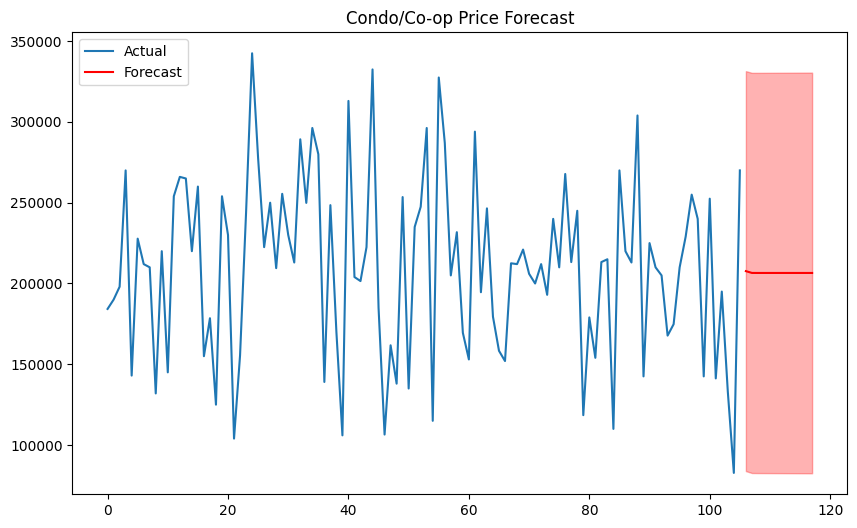

In [335]:
plt.plot(condo_coop[target],label="Actual")
plt.plot(range(len(condo_coop), len(condo_coop) + 12),
         condo_coop_forecast_df["mean"], label="Forecast", color="red"
)
plt.fill_between(range(len(condo_coop), len(condo_coop) + 12),
                 condo_coop_forecast_df["mean_ci_lower"], condo_coop_forecast_df["mean_ci_upper"],
                 alpha=0.3, color="red")

plt.legend()
plt.title("Condo/Co-op Price Forecast")
plt.show()

<Figure size 1500x700 with 0 Axes>

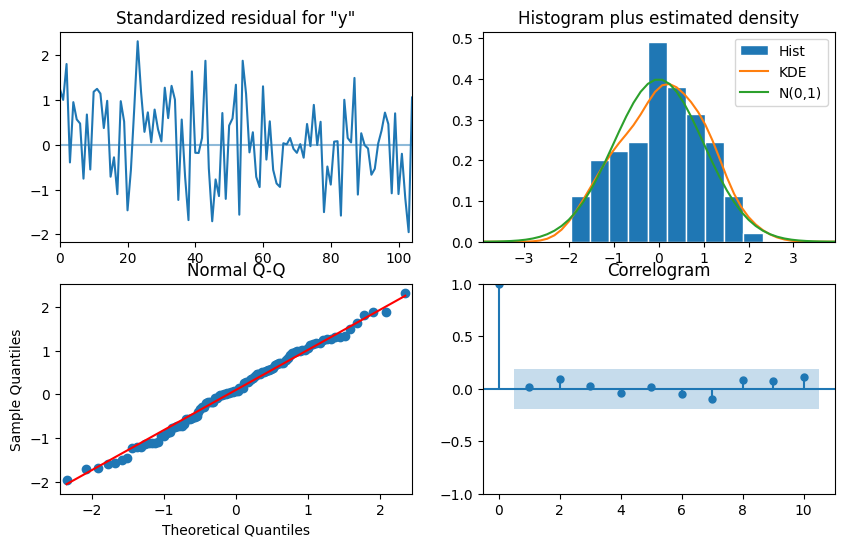

In [336]:
plt.figure(figsize=(15, 7))
condo_coop_fit.plot_diagnostics()
plt.show()

In [337]:
meck_data = county_df_clean.filter(
    pl.col("region") == "Mecklenburg County, NC"
).sort("period_begin")

In [338]:
meck_data.select("property_type").unique().to_numpy().flatten()

array(['Condo/Co-op', 'All Residential', 'Single Family Residential',
       'Multi-Family (2-4 Unit)', 'Townhouse'], dtype=object)

In [339]:
selection = alt.selection_point(fields=["property_type"], bind="legend")

alt.Chart(meck_data).mark_line().encode(
    x=alt.X('period_begin:T'),
    y=alt.Y(f'{target}:Q'),
    color=alt.Color('property_type:N', title='Property Type'),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).properties(
    width=800,
    height=400,
    title="Mecklenburg County - All Property Types Median Sale Price"
).add_params(selection).interactive()

alt.Chart(...)

In [340]:
for col in meck_data.select(cs.float()).drop(["pending_sales_mom", "pending_sales_yoy"]).columns:
    adf_stat, p_val, *_ = adfuller(meck_data.select(col))
    print(f"{col}: {"Stationary" if p_val < 0.05 else "Non-stationary"} (p={p_val:.4f})")

median_sale_price: Non-stationary (p=0.9174)
median_sale_price_mom: Stationary (p=0.0000)
median_sale_price_yoy: Stationary (p=0.0268)
median_list_price: Non-stationary (p=0.8752)
median_ppsf: Non-stationary (p=0.9823)
homes_sold_mom: Stationary (p=0.0000)
homes_sold_yoy: Non-stationary (p=0.2773)
new_listings_mom: Stationary (p=0.0000)
new_listings_yoy: Non-stationary (p=0.1102)
inventory_mom: Stationary (p=0.0000)
inventory_yoy: Non-stationary (p=0.8243)
months_of_supply: Non-stationary (p=0.1642)
months_of_supply_mom: Stationary (p=0.0000)
months_of_supply_yoy: Stationary (p=0.0000)
avg_sale_to_list: Stationary (p=0.0011)
sold_above_list: Non-stationary (p=0.2323)
price_drops: Stationary (p=0.0001)
price_drops_mom: Stationary (p=0.0000)
price_drops_yoy: Stationary (p=0.0017)
off_market_in_two_weeks: Stationary (p=0.0428)


In [341]:
model = ARIMA(meck_data.select(target).to_numpy(), order=(1, 1, 1))
results = model.fit()

In [342]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  508
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6187.521
Date:                Mon, 01 Dec 2025   AIC                          12381.042
Time:                        00:46:46   BIC                          12393.727
Sample:                             0   HQIC                         12386.016
                                - 508                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0509      0.060     -0.847      0.397      -0.169       0.067
ma.L1         -0.9269      0.023    -40.465      0.000      -0.972      -0.882
sigma2      2.816e+09   6.89e-13   4.09e+21      0.000    2.82e+09    2.82e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 1.79
Prob(Q):                              0.71   Prob(JB):                         0.41
Heteroskedasticity (H):               1.00   Skew:                            -0.09
Prob(H) (two-sided):                  0.98   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.03e+37. Standard errors may be unstable.
"""

In [343]:
model = ARIMA(meck_data.select(target).to_numpy(), order=(0, 1, 1))
results = model.fit()

In [344]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  508
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -6188.103
Date:                Mon, 01 Dec 2025   AIC                          12380.206
Time:                        00:46:46   BIC                          12388.663
Sample:                             0   HQIC                         12383.523
                                - 508                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9317      0.021    -45.349      0.000      -0.972      -0.891
sigma2      2.822e+09    8.1e-14   3.48e+22      0.000    2.82e+09    2.82e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.97   Jarque-Bera (JB):                 1.78
Prob(Q):                              0.16   Prob(JB):                         0.41
Heteroskedasticity (H):               1.01   Skew:                            -0.09
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

# Deep Learning
---

In [345]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.transforms import ToTensor
from featurewiz_polars import FeatureWiz
from abc import ABC, abstractmethod
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [346]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device

'cuda'

In [347]:
TSA_TRAIN = DATA_PATH / "processed/tsa_train.csv"
TSA_TEST  = DATA_PATH / "processed/tsa_test.csv" 

In [348]:
cols_to_drop = ["period_begin", "period_end", "state_code", "quarter_label", "year_quarter", "market_phase"]

In [349]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(GRU, self).__init__()
        self.m_hidden_size = hidden_size
        self.m_num_layers  = num_layers

        # gru layers
        self.m_gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # fully connected output layer
        self.m_fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # init hidden state
        h0 = torch.zeros(self.m_num_layers, x.size(0), self.m_hidden_size).to(device=x.device)

        # forward prop
        out, _ = self.m_gru(x, h0)

        # get output from last time step
        out = self.m_fc(out[:, -1, :])
        return out

In [ ]:
class Optimize:
    def __init__(self, model: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, scaler_x=None, scaler_y=None,  device:str="cuda", lr: float=1e-3):
        self.m_model  = model
        self.m_train_dataloader = train_dataloader
        self.m_test_dataloader = test_dataloader
        self.m_lr     = lr
        self.m_cploss = nn.MSELoss()
        self.m_optim  = torch.optim.Adam(self.m_model.parameters(), lr=self.m_lr)
        self.m_device = device
        self.m_model.to(self.m_device)
        self.m_scaler_x = scaler_x
        self.m_scaler_y = scaler_y

        self.train_losses = []
        self.test_losses  = []

    @staticmethod
    def split_data(data: pl.DataFrame, target: str, lookback: int=12):
        features = data.drop(target)

        X, y = [], []
        for i in range(len(features) - lookback):
            X.append(features[i:i+lookback])
            y.append(features[i+lookback, 0])
        
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)

        return X, y
    
    @staticmethod
    def preprocess_data(X_train, X_test, y_train, y_test):
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
        
        n_samples, n_timesteps, n_features = X_train.shape
        
        X_train_2d = X_train.reshape(-1, n_features)
        X_train_scaled_2d = scaler_x.fit_transform(X_train_2d)
        X_train_scaled = X_train_scaled_2d.reshape(n_samples, n_timesteps, n_features)
        
        X_test_2d = X_test.reshape(-1, n_features)
        X_test_scaled_2d = scaler_x.transform(X_test_2d)
        X_test_scaled = X_test_scaled_2d.reshape(X_test.shape[0], n_timesteps, n_features)

        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))
        
        return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_x, scaler_y

    def train(self):
        size = len(self.m_train_dataloader.dataset)
        self.m_model.train()
        train_loss = 0

        for batch, (X, y) in enumerate(self.m_train_dataloader):
            X, y = X.to(self.m_device), y.to(self.m_device)

            # compute prediction error/forward pass
            pred = self.m_model(X)
            loss = self.m_cploss(pred, y)

            # backprop
            self.m_optim.zero_grad()
            loss.backward()
            self.m_optim.step()

            train_loss += loss.item()

            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

        avg_train_loss = train_loss / len(self.m_train_dataloader)
        self.train_losses.append(avg_train_loss)
        return avg_train_loss

    def test(self):
        size = len(self.m_test_dataloader.dataset)
        num_batches = len(self.m_test_dataloader)
        self.m_model.eval()
        test_loss = 0
        
        with torch.no_grad():
            for X, y in self.m_test_dataloader:
                X, y = X.to(self.m_device), y.to(self.m_device)
                pred = self.m_model(X)
                test_loss += self.m_cploss(pred, y).item()
        
        test_loss /= num_batches
        self.test_losses.append(test_loss)
        print(f"Test Error: Avg loss: {test_loss:>8f}\n")
        return test_loss

    def fit(self, epochs: int=5):
        # for t in range(epochs):
        #     print(f"Epoch {t+1}\n-----------------------")
        #     self.train()
        #     self.test()
        # print("Done")
        

    def make_predictions(self, return_original_scale=True):
        self.m_model.eval()
        predictions_scaled = []
        actuals_scaled     = []
        
        with torch.no_grad():
            for X, y in self.m_test_dataloader:
                X = X.to(self.m_device)
                pred = self.m_model(X)
                predictions_scaled.append(pred.cpu().numpy())
                actuals_scaled.append(y.numpy())


        print(f"\nNumber of batches: {len(predictions_scaled)}")
        print(f"Shapes in list:")
        for i, (p, a) in enumerate(zip(predictions_scaled, actuals_scaled)):
            print(f"  Batch {i}: pred {p.shape}, actual {a.shape}")

        try:
            predictions_scaled = np.concatenate(predictions_scaled, axis=0)
            print("predictions: success")
        except Exception as e:
            print(f"predictions: failed -> {e}")

        try:
            actuals_scaled = np.concatenate(actuals_scaled, axis=0)
            print("actuals: success")
        except Exception as e:
            print(f"actuals: failed -> {e}")

        if return_original_scale and self.m_scaler_y is not None:
            predictions_original = self.m_scaler_y.inverse_transform(predictions_scaled)
            actuals_original     = self.m_scaler_y.inverse_transform(actuals_scaled)
            return predictions_original, actuals_original
        else:
            return predictions_scaled, actuals_scaled

In [ ]:
tsa_train_df = pl.read_csv(TSA_TRAIN).drop(cols_to_drop).drop_nulls()
tsa_test_df  = pl.read_csv(TSA_TEST).drop(cols_to_drop).drop_nulls()
tsa_train_X, tsa_train_y = Optimize.split_data(tsa_train_df, target)
tsa_test_X, tsa_test_y   = Optimize.split_data(tsa_test_df, target)
tsa_X_train_scaled, tsa_X_test_scaled, tsa_y_train_scaled, tsa_y_test_scaled, scaler_x, scaler_y = Optimize.preprocess_data(tsa_train_X, tsa_test_X, tsa_train_y, tsa_test_y)
train_dataset = TensorDataset(torch.FloatTensor(tsa_X_train_scaled), torch.FloatTensor(tsa_y_train_scaled))
test_dataset  = TensorDataset(torch.FloatTensor(tsa_X_test_scaled), torch.FloatTensor(tsa_y_test_scaled))

In [ ]:
input_size  = tsa_train_df.shape[1] - 1
batch_size  = 64
hidden_size = 64
num_layers  = 2
output_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

In [363]:
gru = GRU(input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size, dropout=0)
optim = Optimize(gru, train_dataloader, test_dataloader, scaler_x, scaler_y, device, 0.0001)
optim.fit(epochs=10)

Epoch 1
-----------------------
loss: 0.006115 [   64/11854]
loss: 0.000401 [ 6464/11854]
Test Error: Avg loss: 0.485013

Epoch 2
-----------------------
loss: 1.024713 [   64/11854]
loss: 0.000397 [ 6464/11854]
Test Error: Avg loss: 0.263592

Epoch 3
-----------------------
loss: 0.648521 [   64/11854]
loss: 0.000327 [ 6464/11854]
Test Error: Avg loss: 0.157793

Epoch 4
-----------------------
loss: 0.443413 [   64/11854]
loss: 0.000140 [ 6464/11854]
Test Error: Avg loss: 0.092621

Epoch 5
-----------------------
loss: 0.306940 [   64/11854]
loss: 0.000115 [ 6464/11854]
Test Error: Avg loss: 0.047336

Epoch 6
-----------------------
loss: 0.209503 [   64/11854]
loss: 0.000102 [ 6464/11854]
Test Error: Avg loss: 0.027925

Epoch 7
-----------------------
loss: 0.159609 [   64/11854]
loss: 0.000093 [ 6464/11854]
Test Error: Avg loss: 0.020340

Epoch 8
-----------------------
loss: 0.134972 [   64/11854]
loss: 0.000086 [ 6464/11854]
Test Error: Avg loss: 0.016865

Epoch 9
----------------

In [365]:
predictions_original, actuals_original = optim.make_predictions()


Number of batches: 38
Shapes in list:
  Batch 0: pred (64, 1), actual (64, 1)
  Batch 1: pred (64, 1), actual (64, 1)
  Batch 2: pred (64, 1), actual (64, 1)
  Batch 3: pred (64, 1), actual (64, 1)
  Batch 4: pred (64, 1), actual (64, 1)
  Batch 5: pred (64, 1), actual (64, 1)
  Batch 6: pred (64, 1), actual (64, 1)
  Batch 7: pred (64, 1), actual (64, 1)
  Batch 8: pred (64, 1), actual (64, 1)
  Batch 9: pred (64, 1), actual (64, 1)
  Batch 10: pred (64, 1), actual (64, 1)
  Batch 11: pred (64, 1), actual (64, 1)
  Batch 12: pred (64, 1), actual (64, 1)
  Batch 13: pred (64, 1), actual (64, 1)
  Batch 14: pred (64, 1), actual (64, 1)
  Batch 15: pred (64, 1), actual (64, 1)
  Batch 16: pred (64, 1), actual (64, 1)
  Batch 17: pred (64, 1), actual (64, 1)
  Batch 18: pred (64, 1), actual (64, 1)
  Batch 19: pred (64, 1), actual (64, 1)
  Batch 20: pred (64, 1), actual (64, 1)
  Batch 21: pred (64, 1), actual (64, 1)
  Batch 22: pred (64, 1), actual (64, 1)
  Batch 23: pred (64, 1), ac

In [366]:
rmse = np.sqrt(mean_squared_error(actuals_original, predictions_original))
r2 = r2_score(actuals_original, predictions_original)

print(f"\nRMSE: {rmse:,.2f}")
print(f"R²: {r2:.4f}")

print("\nFirst 10 predictions:")
print(f"{'Actual':>12} {'Predicted':>12} {'Error':>12}")
print("-" * 40)
for i in range(min(10, len(predictions_original))):
    actual = actuals_original[i, 0]
    pred = predictions_original[i, 0]
    error = actual - pred
    print(f"{actual:>12.2f} {pred:>12.2f} {error:>12.2f}")


RMSE: 319.35
R²: 0.7266

First 10 predictions:
      Actual    Predicted        Error
----------------------------------------
    27013.00     27875.43      -862.43
    27013.00     27882.73      -869.73
    27013.00     27893.84      -880.84
    27013.00     27909.88      -896.88
    27013.00     27925.93      -912.93
    27013.00     27933.33      -920.32
    27013.00     27931.80      -918.80
    27013.00     27930.66      -917.66
    27013.00     27931.71      -918.71
    27013.00     27931.96      -918.96


In [367]:
optim.train_losses[-10:]

[0.018650690713618513,
 0.05002993792082654,
 0.03600506786731648,
 0.020011194976901334,
 0.01073836948677537,
 0.006204360314680549,
 0.004425826239571262,
 0.0036807322754729313,
 0.0032842248385487015,
 0.0030160212263972523]